In [1]:
import time

from pyAgrum.lib.bn2graph import BN2dot
import numpy as np
import pandas as pd

import pyAgrum as gum
import pyAgrum.lib.notebook as gnb
import pyAgrum.lib.explain as ex

import matplotlib.pyplot as plt

print(ex.ShapValues.__doc__)


  The ShapValue class implements the calculation of Shap values in Bayesian networks.

  The main implementation is based on Conditional Shap values [3]_, but the Interventional calculation method proposed in [2]_ is also present. In addition, a new causal method, based on [1]_, is implemented which is well suited for Bayesian networks.

  Parameters
  ----------
  bn : gum.BayesNet
    The Bayesian network

  target : str
    the name of the target node


.. [1] Heskes, T., Sijben, E., Bucur, I., & Claassen, T. (2020). Causal Shapley Values: Exploiting Causal Knowledge. 34th Conference on Neural Information Processing Systems. Vancouver, Canada.

.. [2] Janzing, D., Minorics, L., & Blöbaum, P. (2019). Feature relevance quantification in explainable AI: A causality problem. arXiv: Machine Learning. Retrieved 6 24, 2021, from https://arxiv.org/abs/1910.13413

.. [3] Lundberg, S. M., & Su-In, L. (2017). A Unified Approach to Interpreting Model. 31st Conference on Neural Information Proc

# Building the model

We build a simple graph for the example

In [2]:
template=gum.fastBN("X1->X2->Y;X3->Z->Y;X0->Z;X1->Z;X2->R[5];Z->R;X1->Y")
data_path = "res/shap/Data_6var_direct_indirect.csv" 

#gum.generateCSV(template,data_path,1000)

learner = gum.BNLearner(data_path,template)
bn = learner.learnParameters(template.dag())
bn

(gum::BayesNet<double>@000001F9D26BCCA0) BN{nodes: 7, arcs: 9, domainSize: 320, dim: 62}

We then create a `pandas.DataFrame` with this base.

In [3]:
train = pd.read_csv(data_path).sample(frac=1.)

# ShapValues()

The ShapValue class implements the calculation of Shap values in Bayesian networks. It is necessary to specify a target and to provide a Bayesian network whose parameters are known and will be used later in the different calculation methods.

In [4]:
gumshap = ex.ShapValues(bn, 'Y')

## Compute Conditionnal in Bayesian Network

A dataset must be provided so that the Bayesian network can learn its parameters and then predict.

The method `conditional` computes the conditonal shap values using the Bayesian Networks. It returns 2 graphs and a dictionary. The first one shows the distribution of the shap values for each of the variables, the second one classifies the variables by their importance.

Run Time : 8.274927854537964 sec


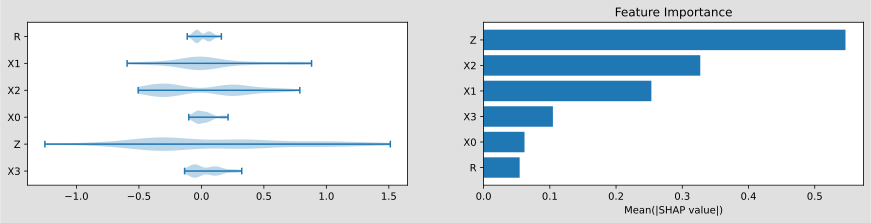

In [5]:
t_start = time.time()
resultat = gumshap.conditional(train, plot=True,plot_importance=True,percentage=False)
print(f'Run Time : {time.time()-t_start} sec')

Run Time : 8.088794946670532 sec


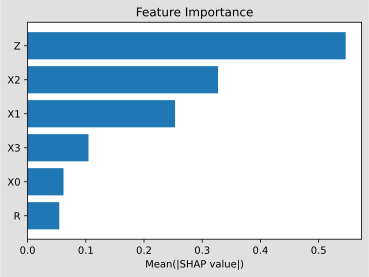

In [15]:
t_start = time.time()
resultat = gumshap.conditional(train, plot=False,plot_importance=True,percentage=False)
print(f'Run Time : {time.time()-t_start} sec')

Run Time : 8.525001287460327 sec


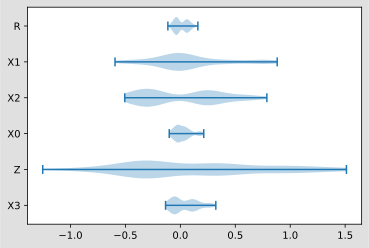

In [16]:
t_start = time.time()
resultat = gumshap.conditional(train, plot=True,plot_importance=False,percentage=False)
print(f'Run Time : {time.time()-t_start} sec')

The result is returned as a dictionary, the keys are the names of the features and the associated value is the absolute value of the average of the calculated shap.

In [17]:
t_start = time.time()
resultat = gumshap.conditional(train, plot=False,plot_importance=False,percentage=False)
print(f'Run Time : {time.time()-t_start} sec')
resultat

Run Time : 8.11944317817688 sec


{'X3': 0.10465402104047894,
 'Z': 0.5464180054433385,
 'X0': 0.06176712200000176,
 'X2': 0.32716064437520065,
 'X1': 0.2533375405370652,
 'R': 0.054456334441524}

## Prediction on Markov Blanket

This method is similar to the previous one, except the method of computation. It computes the conditional shap value but it uses the dataset even when the parameter are learned by the Bayesian Network.

Run Time : 100.19505548477173 sec


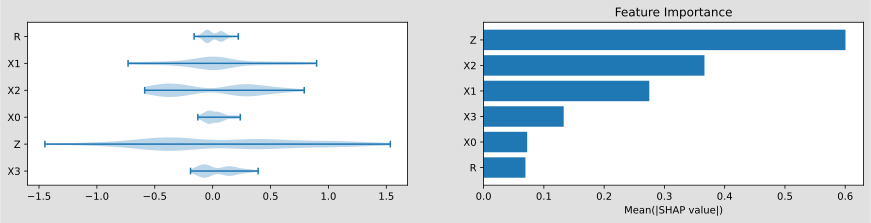

In [7]:
t_start = time.time()
markov = gumshap.conditionalMarkovBlanket(train, plot=True,plot_importance=True,percentage=False)
print(f'Run Time : {time.time()-t_start} sec')

# Causal Shap Values

This method is similar to the previous one, except the formula of computation. It computes the causal shap value as described in the paper of Heskes *Causal Shapley Values: Exploiting Causal Knowledge
to Explain Individual Predictions of Complex Models* .

Run Time : 9.684025049209595 sec


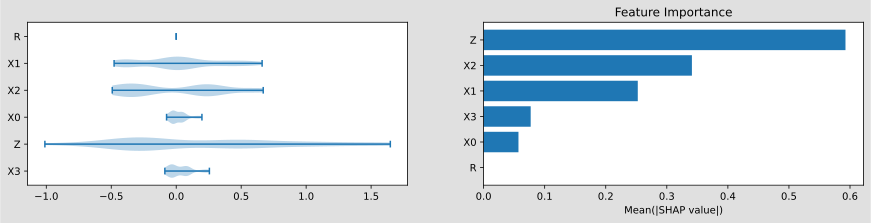

In [8]:
t_start = time.time()
causal = gumshap.causal(train, plot=True, plot_importance=True, percentage=False)
print(f'Run Time : {time.time()-t_start} sec')

As you can see, since $R$ is not among the 'causes' of Y, its causal importance is null.

# Marginal Shap Values

Similarly, one can also compute marginal Shap Value.

Run Time : 38.35093021392822 sec
{'X3': 0.0, 'Z': 0.6089468242404903, 'X0': 0.0, 'X2': 0.4792662974434153, 'X1': 0.4956624037344707, 'R': 0.0}


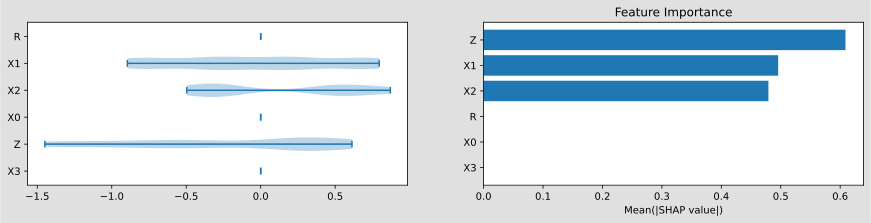

In [10]:
t_start = time.time()
marginal = gumshap.marginal(train, sample_size=10, plot=True,plot_importance=True,percentage=False)
print(f'Run Time : {time.time()-t_start} sec')
print(marginal)

As you can see, since $R$, $X0$ and $X3$ are no in the Markov Blanket of $Y$, their importances is null.

# Colored BN

This method returns a coloured graph that makes it easier to understand which variable is important and where it is located in the graph.

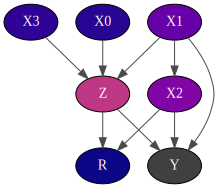

In [14]:
import pyAgrum.lib.notebook as gnb

g = gumshap.showShapValues(causal)
gnb.showGraph(g)